# Kiva Crowdfunding - Loans that change Lives

*Kiva is an international nonprofit organization with a mission to connect people through lending to alleviate poverty. Kiva.org is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. Kiva lenders have provided over $1 billion dollars in loans to over 2 million people.*

## Project Goal

** Not all loans requested through KIVA are funded (about 3383 records in loans dataset that are not funded). In this project, we are trying to identify if a pattern exists among loans that are not getting funded. Our goal is to predict if a Loan is likely to get fully funded or not. As part of this analysis we determine the features that are of the highest importance to get a loan funded.**

In this notebook, we present three different perspective based on each of our analysis while achieving our common goal to predict if a loan is likely to get funded or not.

In [1]:
%matplotlib inline

# General libraries.
import re
import math
import numpy as np
import collections
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from mpl_toolkits.basemap import Basemap
color = sns.color_palette()
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture # For clustering 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
import pydot
import graphviz

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

C:\Users\Amrit\New_Version_Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



## VERSION # 1

## 1a: Data Loading

In [2]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")
df_kiva_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


## 1b: EDA

In [3]:
# Identify rows with no funding (Funding amount = 0)
df_nofund = df_kiva_loans[(df_kiva_loans['funded_amount']==0)]
df_nofund.shape

(3383, 20)


 **There are about 3383 rows with funded amount = 0**  

** MORE OBSERVATIONS **

- Philippines, Kenya and El Salvador are the top 3 countries featuring in Loans dataset based on the number of records  
- United States, Kenya and Pakistan are the countries top countries with loan amount not funded
- Agriculture, Food and Retail are the top 3 sectors based on Loan Amount
- Farming is the top activity based on Loan Amount, followed by General Store and Personal Housing Expenses
- There are more Female borrowers than male

NOTE: The EDA charts related to these observations have not been included since focus of this project is on the models. 

In [4]:
countries_funded_amount = df_kiva_loans.groupby('country').mean()['funded_amount'].sort_values(ascending = False)
print("Top Countries with funded amount (Mean values)\n",countries_funded_amount.head(10))
data = [dict(
        type='choropleth',
        locations= countries_funded_amount.index,
        locationmode='country names',
        z=countries_funded_amount.values,
        text=countries_funded_amount.index,
        colorscale='Red',
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='Top Countries with funded_amount(Mean value)'),
)]
layout = dict(title = 'Countries based on Funded amount',
             geo = dict(
            showframe = False,
            #showcoastlines = False,
            projection = dict(
                type = 'Mercatorodes'
            )
        ),)
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False)

Top Countries with funded amount (Mean values)
 country
Cote D'Ivoire         50000.000000
Mauritania            15000.000000
Bhutan                 7812.500000
Chile                  7625.000000
Afghanistan            7000.000000
Congo                  6142.578125
Puerto Rico            4409.191176
Dominican Republic     4200.604839
Namibia                4046.875000
United States          3800.843591
Name: funded_amount, dtype: float64


In [5]:
# Determine Time Taken for Funding. It is Loan Posted Time - Funded Time

df_funded = df_kiva_loans[(df_kiva_loans['funded_amount']!=0)]
df_funded.dropna()
df_funded.shape

df_funded['funded_time'] = pd.to_datetime(df_funded['funded_time'])
df_funded['posted_time'] = pd.to_datetime(df_funded['posted_time'])    
time_to_fund = (df_funded.funded_time - df_funded.posted_time)
time_to_fund_in_days = (time_to_fund.astype('timedelta64[s]')/(3600 * 24))
df_funded = df_funded.assign(time_to_fund=time_to_fund)
df_funded = df_funded.assign(time_to_fund_in_days=time_to_fund_in_days)

funded_time = df_funded.groupby('country').mean()['time_to_fund_in_days'].sort_values(ascending = False)
print("Top Countries with max funded_time(Mean values)\n",funded_time.head(10))
data = [dict(
        type='choropleth',
        locations= funded_time.index,
        locationmode='country names',
        z=funded_time.values,
        text=funded_time.index,
        colorscale='Red',
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='Countries based on Funded Time'),
)]
layout = dict(title = 'Top Countries - Funded Time',
             geo = dict(
            showframe = False,
            #showcoastlines = False,
            projection = dict(
                type = 'Mercatorodes'
            )
        ),)
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False)

Top Countries with max funded_time(Mean values)
 country
United States    39.544380
Puerto Rico      38.112630
Vanuatu          35.963452
El Salvador      22.054165
Azerbaijan       21.930762
Bolivia          21.458772
Georgia          20.976522
Armenia          20.607393
Colombia         20.366121
Kenya            20.161696
Name: time_to_fund_in_days, dtype: float64


## 1c: Data Pre-processing

In [6]:
use_col = ['funded_amount', 'loan_amount', 'sector', 'country', 'term_in_months', 'borrower_genders', 'repayment_interval']
df_loans = df_kiva_loans[use_col].copy()
df_loans.head()

,funded_amount,loan_amount,sector,country,term_in_months,borrower_genders,repayment_interval
0,300.0,300.0,Food,Pakistan,12.0,female,irregular
1,575.0,575.0,Transportation,Pakistan,11.0,"female, female",irregular
2,150.0,150.0,Transportation,India,43.0,female,bullet
3,200.0,200.0,Arts,Pakistan,11.0,female,irregular
4,400.0,400.0,Food,Pakistan,14.0,female,monthly


In [7]:
df_loans.isnull().sum()

funded_amount            0
loan_amount              0
sector                   0
country                  0
term_in_months           0
borrower_genders      4221
repayment_interval       0
dtype: int64

In [8]:
df_loans.dropna(inplace=True)

In [9]:
df_loans.shape

(666984, 7)

In [10]:
df_loans['percent_female'] = df_loans['borrower_genders'].apply(lambda x: np.mean(np.array(x.split(',')) == 'female'))
df_loans['applicants'] = df_loans['borrower_genders'].apply(lambda x: len(x.split(',')))
df_loans.drop('borrower_genders', axis=1, inplace=True)

In [11]:
df_loans.head()

,funded_amount,loan_amount,sector,country,term_in_months,repayment_interval,percent_female,applicants
0,300.0,300.0,Food,Pakistan,12.0,irregular,1.0,1
1,575.0,575.0,Transportation,Pakistan,11.0,irregular,0.5,2
2,150.0,150.0,Transportation,India,43.0,bullet,1.0,1
3,200.0,200.0,Arts,Pakistan,11.0,irregular,1.0,1
4,400.0,400.0,Food,Pakistan,14.0,monthly,1.0,1


In [12]:
df_loans['granted'] = 1*(df_loans['loan_amount'] == df_loans['funded_amount'])
df_loans.drop('funded_amount', axis=1, inplace=True)

In [13]:
df_loans['granted'].value_counts()

1    619336
0     47648
Name: granted, dtype: int64

** OBSERVATION: There are 47648 that are not fully funded. **

In [14]:
df_loans = pd.concat((df_loans,pd.get_dummies(df_loans[['sector', 'country', 'repayment_interval']], drop_first=True)), axis=1)
df_loans.drop(['sector', 'country', 'repayment_interval'], axis=1, inplace=True)
df_loans.shape
df_loans.head()

df_loans1 = df_loans.copy()
features = df_loans.drop('granted', axis=1).columns

In [15]:
X = df_loans.drop('granted', axis=1).values
y = df_loans['granted'].values
print(X.shape)
print(y.shape)


(666984, 107)
(666984,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 1d: Model Building

### 1. Random Forest

In [17]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
print("Score from Random Forest is %.2f%%" %(score*100))
y_pred = rfc.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

Score from Random Forest is 92.61%
True Positive= 200024
False Positive= 11979
True Negative= 3820
False Negative= 4282


In [18]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.47      0.24      0.32     15799
          1       0.94      0.98      0.96    204306

avg / total       0.91      0.93      0.91    220105



** OBSERVATION: Even though Random Forest model gave an accuracy score of 92.6%, it did bad on predicting class 0 (only 33% score on predicting loans that are not fully funded). There are close to 12K False Positives and 4K False Negatives. Also notice, the data between class 0 and 1 is uneven/imbalanced.**

### Feature Importance from Random Forest

In [19]:
importances = pd.DataFrame({"Feature": features, 'Score': rfc.feature_importances_})
importances = importances.sort_values(by='Score', ascending=False).head(10)

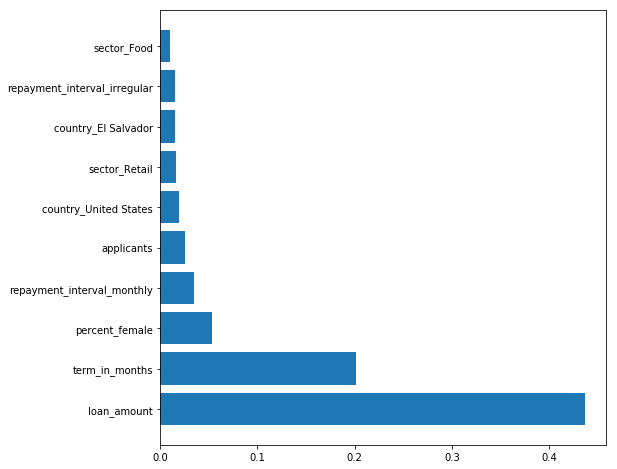

In [20]:
plt.figure(figsize=(8,8))
plt.barh(range(10), importances['Score'])
a = plt.yticks(range(10), importances['Feature'])

### 2. Decision Tree

In [21]:
clf = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth=3, min_samples_leaf=5, min_samples_split=10)
clf.fit(X_train, y_train)
print ('Accuracy:', clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


Accuracy: 0.9282206219758752
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     15799
          1       0.93      1.00      0.96    204306

avg / total       0.86      0.93      0.89    220105



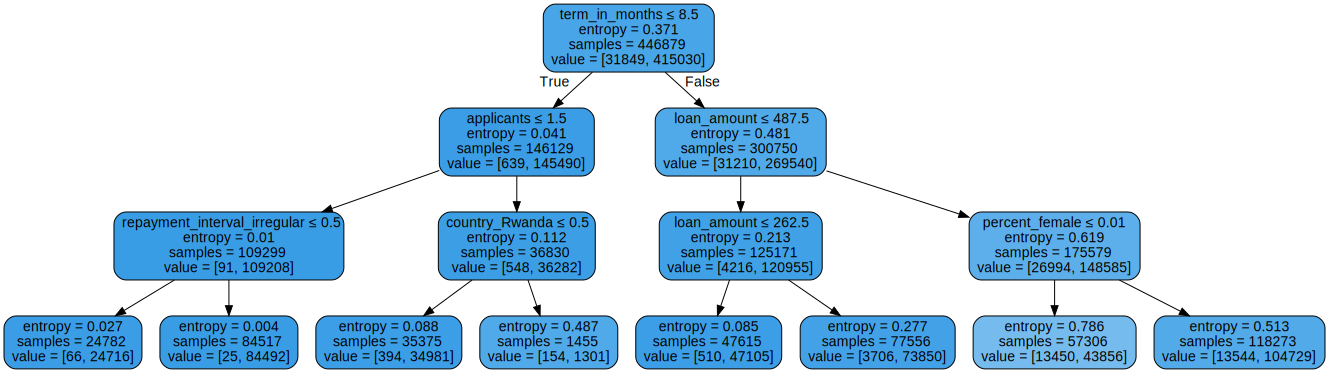

In [22]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=features,  
                      #class_names=y_test,  
                      filled=True, rounded=True,  
                      special_characters=True)


graph = graphviz.Source(dot_data)  
graph 

** OBSERVATION: Even though Decision Tree model gave an accuracy score of 92.8%, it did worse on predicting class 0 (0% score on predicting loans that are not fully funded). **

### 3. XGBoost

In [23]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

print ('Accuracy:', clf_xgb.score(X_test, y_test))

y_pred = clf_xgb.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

             precision    recall  f1-score   support

          0       0.82      0.04      0.08     15799
          1       0.93      1.00      0.96    204306

avg / total       0.92      0.93      0.90    220105

Accuracy: 0.9306285636400808
True Positive= 204161
False Positive= 15124
True Negative= 675
False Negative= 145


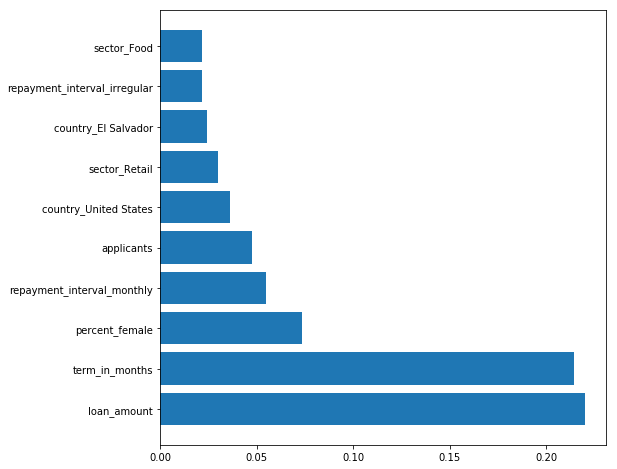

In [24]:
imp = pd.DataFrame({"Feature": features, "Score": clf_xgb.feature_importances_ })
imp = imp.sort_values(by = 'Score', ascending = False).head(10)
plt.figure(figsize= (8,8))
plt.barh(range(10),imp["Score"])
a = plt.yticks(range(10), importances["Feature"])

** OBSERVATION: XGBoost scored only 8% on Class 0 (loans that are not fully funded) while Class 1 (fully funded) was predicted at 96%. **

### 4. Logistic Regression - UNADJUSTED

In [25]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print("Score from Logisitic Regression is %.2f%%" %(score*100))

print(classification_report(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

Score from Logisitic Regression is 92.77%
             precision    recall  f1-score   support

          0       0.46      0.04      0.07     15799
          1       0.93      1.00      0.96    204306

avg / total       0.90      0.93      0.90    220105

True Positive= 203643
False Positive= 15245
True Negative= 554
False Negative= 663


### 5. Logistic Regression with Balanced Class weight and Grid Search Best Parameters

In [26]:
lgr = LogisticRegression(penalty = 'l2', C=0.5)
lgr.fit(X_train,y_train)
 
cval = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 20.0, 30.0, 50.0, 100.0]}
grid = GridSearchCV(estimator=lgr, param_grid=cval, cv=5,scoring='f1_weighted' )
grid.fit(X_train, y_train)
print('The best value for C', grid.best_params_)
print('The best score',grid.best_score_)

The best value for C {'C': 0.5}
The best score 0.8985605099159708


In [27]:
lgr = LogisticRegression(class_weight="balanced", penalty = 'l2', C=0.5)
lgr.fit(X_train,y_train)
predict = lgr.predict(X_test)
score1 = lgr.score(X_test, y_test)
print("Score from Logisitic Regression with balanced class is %.2f%%" %(score1*100))

print(classification_report(y_test, predict))

confusion_matrix(y_test, predict)
tn, fp, fn, tp = confusion_matrix(y_test, predict, labels=[0,1]).ravel()
print ('Confusion Matrix after adding Class_weight')
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

Score from Logisitic Regression with balanced class is 72.57%
             precision    recall  f1-score   support

          0       0.17      0.76      0.28     15799
          1       0.97      0.72      0.83    204306

avg / total       0.92      0.73      0.79    220105

Confusion Matrix after adding Class_weight
True Positive= 147746
False Positive= 3820
True Negative= 11979
False Negative= 56560


### 6. Logistic Regression after Downsampling

In [28]:
# Separate majority and minority classes
from sklearn.utils import resample
df_majority = df_loans1[df_loans1.granted == 1]
df_minority = df_loans1[df_loans1.granted == 0]
df_minority.shape

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=47648,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.granted.value_counts()

1    47648
0    47648
Name: granted, dtype: int64

In [29]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    df_downsampled.drop('granted', axis=1).values, df_downsampled['granted'].values, 
                 test_size=0.33, random_state=42)

In [30]:
# Separate input features (X) and target variable (y)

# Train model
clf_2 = LogisticRegression(class_weight="balanced", penalty = 'l2', C=0.5).fit(X_train_balanced, y_train_balanced)
 
# Predict 
y_pred = clf_2.predict(X_test_balanced)

score1 = lgr.score(X_test_balanced, y_test_balanced)
print("Score from Logisitic Regression with balanced class is %.2f%%" %(score1*100))

# accuracy
print(classification_report(y_test_balanced, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test_balanced, y_pred, labels=[0,1]).ravel()
print ('Confusion Matrix after adding Class_weight')
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

Score from Logisitic Regression with balanced class is 74.69%
             precision    recall  f1-score   support

          0       0.73      0.77      0.75     15693
          1       0.76      0.72      0.74     15755

avg / total       0.74      0.74      0.74     31448

Confusion Matrix after adding Class_weight
True Positive= 11333
False Positive= 3674
True Negative= 12019
False Negative= 4422


** OBSERVATION: After downsampling, Logistic Regression gave more balanced results with class 0(non funded) score increase from 7% to 75%. However, Class 1 scoring decreased due to the decrease in sample data. Overall, downsampling gave the best results for Logistic Regression **

### 7. Revisit Random Forest with balanced data

In [31]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train_balanced, y_train_balanced)
y_pred = rfc.predict(X_test_balanced)

score1 = rfc.score(X_test_balanced, y_test_balanced)
print("Score from Logisitic Regression with balanced class is %.2f%%" %(score1*100))

print(classification_report(y_test_balanced, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test_balanced, y_pred, labels=[0,1]).ravel()
print ('Confusion Matrix after adding Class_weight')
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

Score from Logisitic Regression with balanced class is 79.85%
             precision    recall  f1-score   support

          0       0.78      0.83      0.80     15693
          1       0.82      0.76      0.79     15755

avg / total       0.80      0.80      0.80     31448

Confusion Matrix after adding Class_weight
True Positive= 12049
False Positive= 2632
True Negative= 13061
False Negative= 3706


** OBSERVATION: After downsampling, Random Forest gave more balanced results with class 0(non funded) score increase from 32% to 80%. However, Class 1 scoring decreased due to the decrease in sample data. Overall, Random Forest after downsampling did better than ANY other model above.**

### Feature Importance based on SelectKBest

In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature extraction
test = SelectKBest(score_func=chi2, k=10)
fit = test.fit(X_train, y_train)
# summarize scores
np.set_printoptions(precision=3)

sorted_features = features[fit.scores_.argsort()]
for i, x in enumerate(features[fit.scores_.argsort()].tolist()[::-1][:10]):
    print(x)

country_Mauritania
country_Cote D'Ivoire
loan_amount
term_in_months
repayment_interval_irregular
country_United States
country_Philippines
country_El Salvador
country_Colombia
percent_female


### 8. Unsupervised Learning

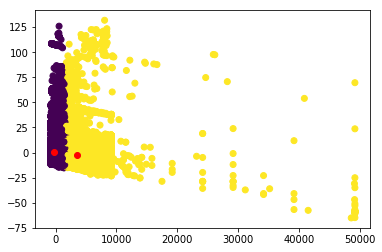

In [33]:
pca = PCA(n_components=10)
train_data_comp = pca.fit_transform(X_train)

test_data_comp = pca.transform(X_test)

km = KMeans(n_clusters=2, init='k-means++')
clstrs = km.fit(train_data_comp)

plt.scatter(train_data_comp[:,0], train_data_comp[:,1], c=clstrs.labels_)
plt.plot(clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1], 'ro')  
plt.show() 


In [34]:
clf_pos = GMM(n_components=2, covariance_type='full')
clf_pos.fit(train_data_comp[y_train == 1, :])

clf_neg = GMM(n_components=2, covariance_type='full')
clf_neg.fit(train_data_comp[y_train == 0, :])

prob_pos = clf_pos.score_samples(test_data_comp)
prob_neg = clf_neg.score_samples(test_data_comp)
    
test_class1 = (prob_pos> prob_neg).astype(int)

print ("GMM Accuracy = %.2f%% percent" %(np.mean(test_class1 == y_test)*100))
print(classification_report(y_test, test_class1))

GMM Accuracy = 65.42% percent
             precision    recall  f1-score   support

          0       0.14      0.73      0.23     15799
          1       0.97      0.65      0.78    204306

avg / total       0.91      0.65      0.74    220105



In [35]:
pca = PCA(n_components=10)
train_data_comp = pca.fit_transform(X_train_balanced)
test_data_comp = pca.transform(X_test_balanced)

clf_pos = GMM(n_components=2, covariance_type='full')
clf_pos.fit(train_data_comp[y_train_balanced == 1, :])

clf_neg = GMM(n_components=2, covariance_type='full')
clf_neg.fit(train_data_comp[y_train_balanced == 0, :])

prob_pos = clf_pos.score_samples(test_data_comp)
prob_neg = clf_neg.score_samples(test_data_comp)
    
test_class1 = (prob_pos> prob_neg).astype(int)

print ("GMM Accuracy = %.2f%% percent" %(np.mean(test_class1 == y_test_balanced)*100))
print(classification_report(y_test_balanced, test_class1))

GMM Accuracy = 70.49% percent
             precision    recall  f1-score   support

          0       0.68      0.76      0.72     15693
          1       0.73      0.65      0.69     15755

avg / total       0.71      0.70      0.70     31448



** OBSERVATION: GMM did a lot better after downsampling (Class 0 score increased from 23% to 72%). However, this is still lower than Supervised Learning prediction.**

## Summary

| Model                                 | Overall Accuracy | 0 score | 1 score | False Positive | False Negative |
|---------------------------------------|------------------|---------|---------|----------------|----------------|
| Random Forest                         |       92.6%      |   32%   |   96%   |      11941     |      4334      |
| Decision Tree                         |       92.8%      |    0%   |   96%   |                |                |
| XG Boost                              |       93.1%      |    8%   |   96%   |      15124     |       675      |
| Logistic Reg - Unadj                  |       92.8%      |    7%   |   96%   |      15245     |       663      |
| Logistic Reg after Parameter tuning   |       72.6%      |   28%   |   83%   |      3820      |      56560     |
| Logistic Reg after Downsampling       |      74.69%      |   75%   |   74%   |      3674      |      4422      |
| Random Forest after Downsampling      |      79.97%      |   81%   |   79%   |      2599      |      3745      |
| Unsupervised -   GMM                  |       65.4%      |   23%   |   78%   |                |                |
| Unsupervised - GMM after Downsampling |      70.47%      |   72%   |   69%   |                |                |

## Version 2

Most EDA is not shown below but is contained in separate notebook.

In [36]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [37]:
kiva_loans = pd.read_csv('kiva_loans.csv')

In [38]:
kiva_loans.head(3)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01


In [39]:
lf = (kiva_loans.funded_amount - kiva_loans.loan_amount)
kiva_loans['funded'] = lf

In [40]:
#Starting binarizing process; changing any value of 0.0 to 1
#which indicates load was fully funded

mask = kiva_loans.funded == 0.0
column_name = 'funded'
kiva_loans.loc[mask, column_name] = 1

In [41]:
#Changing any values that are not 1 to 0 which indicates loan not
#fully funded

alt = kiva_loans.funded != 1.0
column_name = 'funded'
kiva_loans.loc[alt, column_name] = 0

In [42]:
kiva_loans = kiva_loans.dropna(axis=0, subset=['borrower_genders'])

In [43]:
#group genders and apply dummy variables

kiva_loans['gender']=[elem if elem in ['female','male'] else 'group' for elem in kiva_loans['borrower_genders']]
dummy = pd.get_dummies(kiva_loans['gender'])
kiva_loans = pd.concat([kiva_loans,dummy], axis =1)

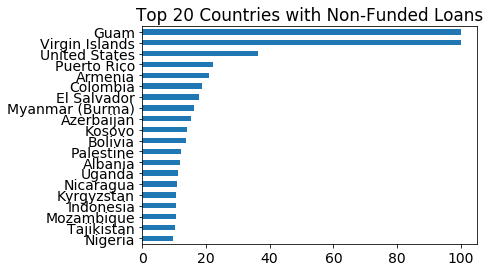

In [44]:
#Plotting percentage of non-funded loans by country; Guam and the Virgin
#Islands have almost a 100% rate of non-funded loans

A = (kiva_loans[kiva_loans['funded']==0]['country'].value_counts()/kiva_loans['country'].value_counts() * 100).sort_values(ascending=False)
A[0:20].sort_values().plot(kind='barh', title='Top 20 Countries with Non-Funded Loans')

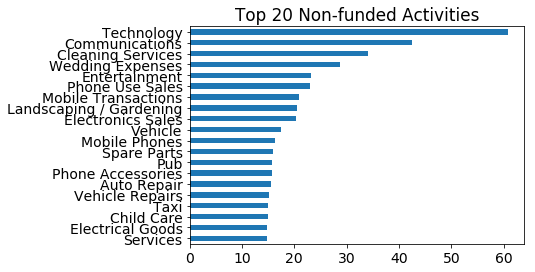

In [45]:
#plotting above data and only showing top 20 activities not funded

B = (kiva_loans[kiva_loans['funded']==0]['activity'].value_counts()/kiva_loans['activity'].value_counts() * 100).sort_values(ascending = False)
B[0:20].sort_values().plot(kind='barh', title='Top 20 Non-funded Activities')

In [46]:
#Create two dataframes: one for funded loans and one for non-funded loans

df_funded = kiva_loans[kiva_loans['funded'] == 1]
df_notfunded = kiva_loans[kiva_loans['funded'] == 0]

In [47]:
#Create funded dataframe with size of 50000 to be comparable to non-funded
#dataframe size; cap df size at 50,000 and choose every 3rd value

df_funded_s = df_funded.sample(n=50000, random_state=3)
df_funded_s.shape

(50000, 25)

In [48]:
#Merge funded sample size dataframe with non-funded dataframe for 
#prediction down below

df_final_s = pd.concat([df_funded_s, df_notfunded], ignore_index=True)
df_final_s.shape

(97648, 25)

Based on extensive EDA, the following variables appeared to influence
whether or not a loan was funded:

- Country
- Lender Count
- Repayment Interval
- Loan Term (in months)
- Activity
- Amount of Loan Request
- Borrower Gender
- Repayment Time

Initially I tried to dummy the relevant features and run Recursive Feature Elimination and reduce 850+ independent variables to top 50. This was too much for RFE. I also tried to run SMOTE on 850+ 'dummied' variables but SMOTE kept timing out.

In [49]:
#first prediction uses 'funded_amount' as independent variable; for this
#first pass, I am not going to make dummy vars with the funded amount

set1 = df_final_s[['funded_amount', 'funded']]
set1.head()

,funded_amount,funded
0,1450.0,1.0
1,850.0,1.0
2,925.0,1.0
3,450.0,1.0
4,350.0,1.0


In [50]:
X = set1.iloc[:, :-1]
y = set1.iloc[:, -1]
print(X.shape)
print(y.shape)

(97648, 1)
(97648,)


In [51]:
#split data into train and test; allocate 30% to test data

#at .52, the accuracy is not very good

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set:{:.2f}'.
      format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set:0.52


In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[7808 6509]
 [7619 7359]]


In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.51      0.55      0.53     14317
        1.0       0.53      0.49      0.51     14978

avg / total       0.52      0.52      0.52     29295



Now create dummies with funded_amount var and see if this improves accuracy.

In [54]:
set1_dum = pd.get_dummies(data=set1, columns=['funded_amount'])
set1_dum.head(1)

,funded,funded_amount_0.0,funded_amount_5.0,funded_amount_10.0,funded_amount_15.0,funded_amount_20.0,funded_amount_25.0,funded_amount_30.0,funded_amount_35.0,funded_amount_40.0,...,funded_amount_16350.0,funded_amount_17050.0,funded_amount_18050.0,funded_amount_18325.0,funded_amount_20000.0,funded_amount_22500.0,funded_amount_30000.0,funded_amount_40000.0,funded_amount_46125.0,funded_amount_50000.0
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
#this moves 'funded' column to last column in dataframe

cols = set1_dum.columns.tolist()
column_to_move = 'funded'
new_position = 498
cols.insert(new_position, cols.pop(cols.index(column_to_move)))
set1_final = set1_dum[cols]
set1_final.head()

,funded_amount_0.0,funded_amount_5.0,funded_amount_10.0,funded_amount_15.0,funded_amount_20.0,funded_amount_25.0,funded_amount_30.0,funded_amount_35.0,funded_amount_40.0,funded_amount_45.0,...,funded_amount_17050.0,funded_amount_18050.0,funded_amount_18325.0,funded_amount_20000.0,funded_amount_22500.0,funded_amount_30000.0,funded_amount_40000.0,funded_amount_46125.0,funded_amount_50000.0,funded
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [56]:
X1 = set1_final.iloc[:, :-1]
y1 = set1_final.iloc[:, -1]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=0)
#logreg = LogisticRegression()
logreg.fit(X1_train, y1_train)

y_pred = logreg.predict(X1_test)
print('Accuracy of logistic regression classifier on test set:{:.2f}'.
      format(logreg.score(X1_test, y1_test)))

print()

print(classification_report(y1_test, y_pred))

Accuracy of logistic regression classifier on test set:0.60

             precision    recall  f1-score   support

        0.0       0.61      0.52      0.56     14317
        1.0       0.60      0.68      0.64     14978

avg / total       0.60      0.60      0.60     29295



#### By binarizing the independent variable, accuracy improved from .52 to .60

#### All models run using Logistic Regression.


| Independent Variable                  | Overall Accuracy | 0 score | 1 score | 
|---------------------------------------|------------------|---------|---------|
| Loan Amount (not 'dummied')           |       51.8%      |   32%   |   96%   |  
| Loan Amount (dummy)                   |       60.3%      |    0%   |   96%   | 
| Activity (dummy)                      |       60.6%      |    8%   |   96%   | 
| Gender (dummy)                        |       63.6%      |    7%   |   96%   |  
| Country (dummy)                       |       66.7%      |   28%   |   83%   | 
| Loan Term in Months (dummy)           |       67.9%      |   75%   |   74%   |  
| Repayment Interval (dummy)            |       62.6%      |   81%   |   79%   |     
| Sector (dummy)                        |       55.8%      |   23%   |   78%   |

  
  
| Loan Term, Country                                   |      70.5%       |   72%   |   69%   |  
| Loan Term, Country, Gender                           |      73.7%       |   72%   |   69%   |
| Loan Term, Country, Gender, Repayment                |      73.3%       |   72%   |   69%   |
| Loan Term, Country, Gender, Repayment, Activity      |      76.4%       |   72%   |   69%   |





#### Combinations (all dummied)

  
| Loan Term, Country                                   |      70.5%       |   72%   |   69%   |  
| Loan Term, Country, Gender                           |      73.7%       |   72%   |   69%   |
| Loan Term, Country, Gender, Repayment                |      73.3%       |   72%   |   69%   |
| Loan Term, Country, Gender, Repayment, Activity      |      76.4%       |   72%   |   69%   |

## Version 3

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
#import ijson

#please use pip to install the module: pip install -U googlemaps & pip install ijson


%matplotlib inline  
print (np.__version__)

# SK-learn libraries for learning.
from sklearn.linear_model import LogisticRegression


# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import linear_model,datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn import cross_validation


# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

1.15.4


## Data cleaning

### we will use column 'funded_amount', 'loan_amount', 'activity', 'sector', 'country', 'term_in_months' and 'borrower_genders' to build the model so we need to make sure there is no null in the dataset.

In [60]:
kiva_loans_data = pd.read_csv("kiva_loans.csv")
kiva_loans_data2 = kiva_loans_data[~kiva_loans_data['borrower_genders'].isnull()].copy(deep=True)
#exclude the data whose funded amount is larger than loan amount
kiva_loans_data2 = kiva_loans_data2[~(kiva_loans_data2['funded_amount']>kiva_loans_data2['loan_amount'])]

## EDA

### make the label for our model: fully funded to 3, not funded to 1, partially funded to 2

In [61]:

conditions = [  (kiva_loans_data2['funded_amount']==(kiva_loans_data2['loan_amount'])),
    (kiva_loans_data2['funded_amount']==0),
    (kiva_loans_data2['funded_amount']<kiva_loans_data2['loan_amount'])]
choices = [3, 1, 2]
kiva_loans_data2['label'] = np.select(conditions, choices)

kiva_loans_data2['genders']=[elem if elem in ['female','male'] else 'group' for elem in kiva_loans_data2['borrower_genders'] ]
dummy = pd.get_dummies(kiva_loans_data2['genders'])
kiva_loans_data2 = pd.concat([kiva_loans_data2,dummy ], axis =1)

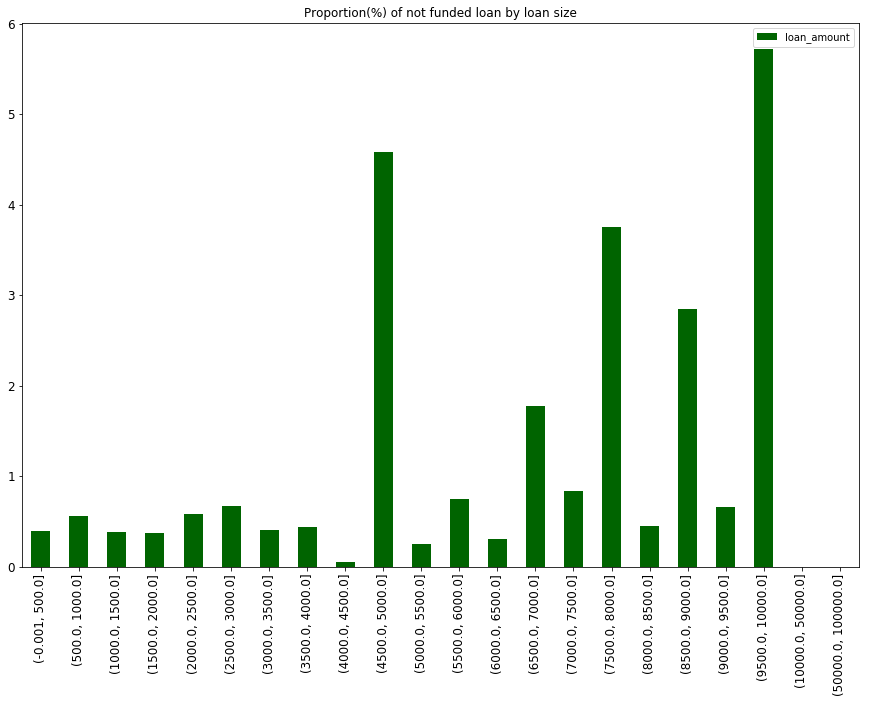

In [62]:
bins = (0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500 ,7000,7500,8000,8500,9000,9500,10000,50000,100000) 
(kiva_loans_data2[kiva_loans_data2['label']==1]['loan_amount'].value_counts(bins = bins).sort_index()/kiva_loans_data2['loan_amount'].value_counts(bins = bins).sort_index()*100).plot(kind='bar', title ="Proportion(%) of not funded loan by loan size", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')


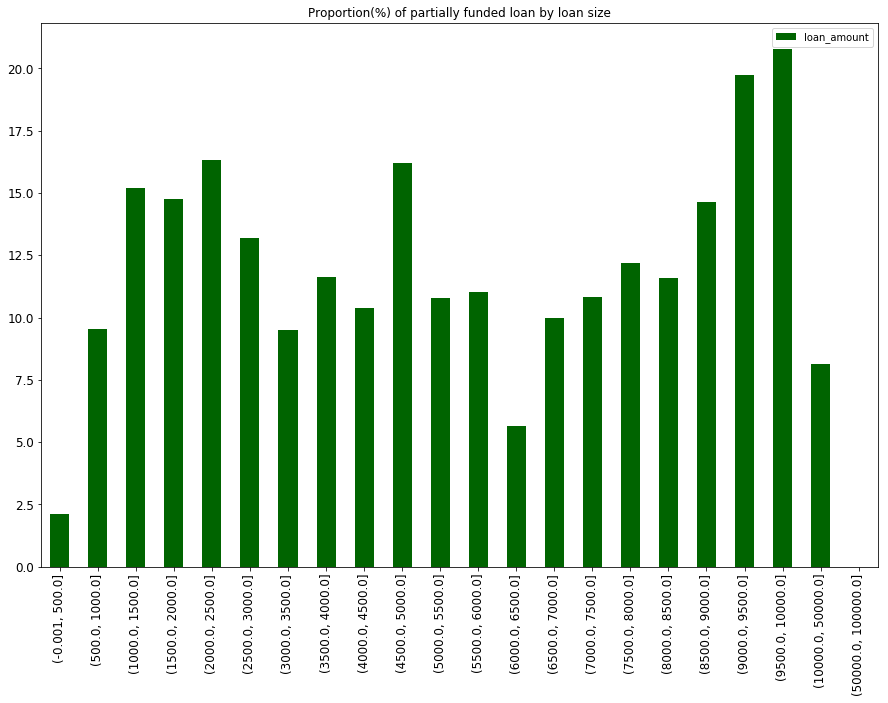

In [63]:
bins = (0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500 ,7000,7500,8000,8500,9000,9500,10000,50000,100000) 
(kiva_loans_data2[kiva_loans_data2['label']==2]['loan_amount'].value_counts(bins = bins).sort_index()/kiva_loans_data2['loan_amount'].value_counts(bins = bins).sort_index()*100).plot(kind='bar', title ="Proportion(%) of partially funded loan by loan size", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')



### We can see larger size has relatively not funded rate.

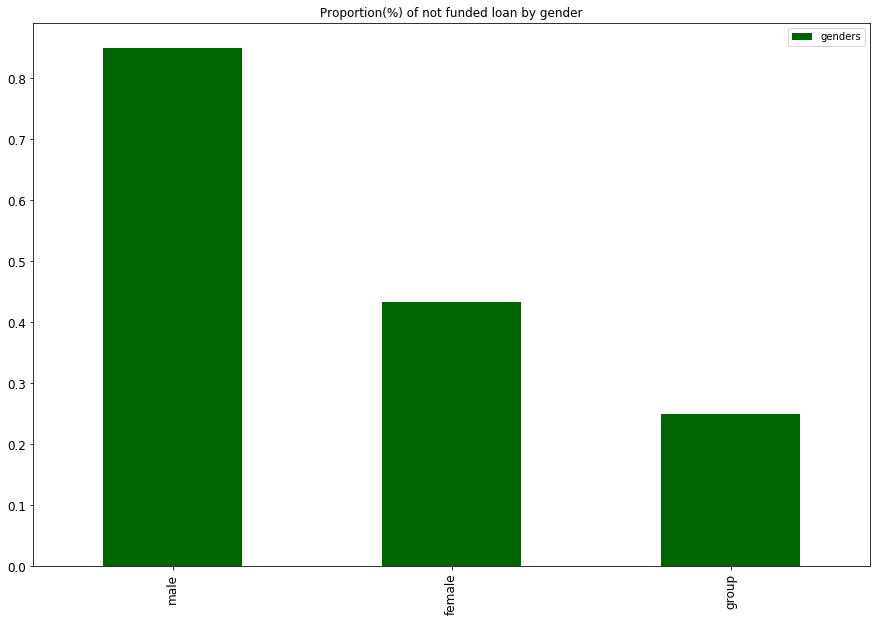

In [64]:
(kiva_loans_data2[kiva_loans_data2['label']==1]['genders'].value_counts()/kiva_loans_data2['genders'].value_counts()*100).sort_values(ascending=False).plot(kind='bar', title ="Proportion(%) of not funded loan by gender", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')

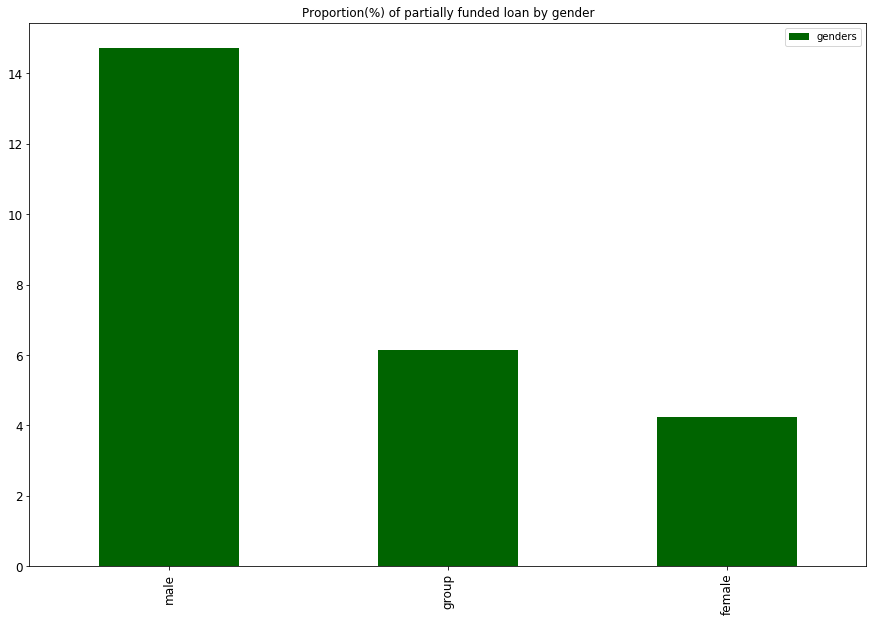

In [65]:
(kiva_loans_data2[kiva_loans_data2['label']==2]['genders'].value_counts()/kiva_loans_data2['genders'].value_counts()*100).sort_values(ascending=False).plot(kind='bar', title ="Proportion(%) of partially funded loan by gender", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')

### We can see that male has higher not/partially funded rate

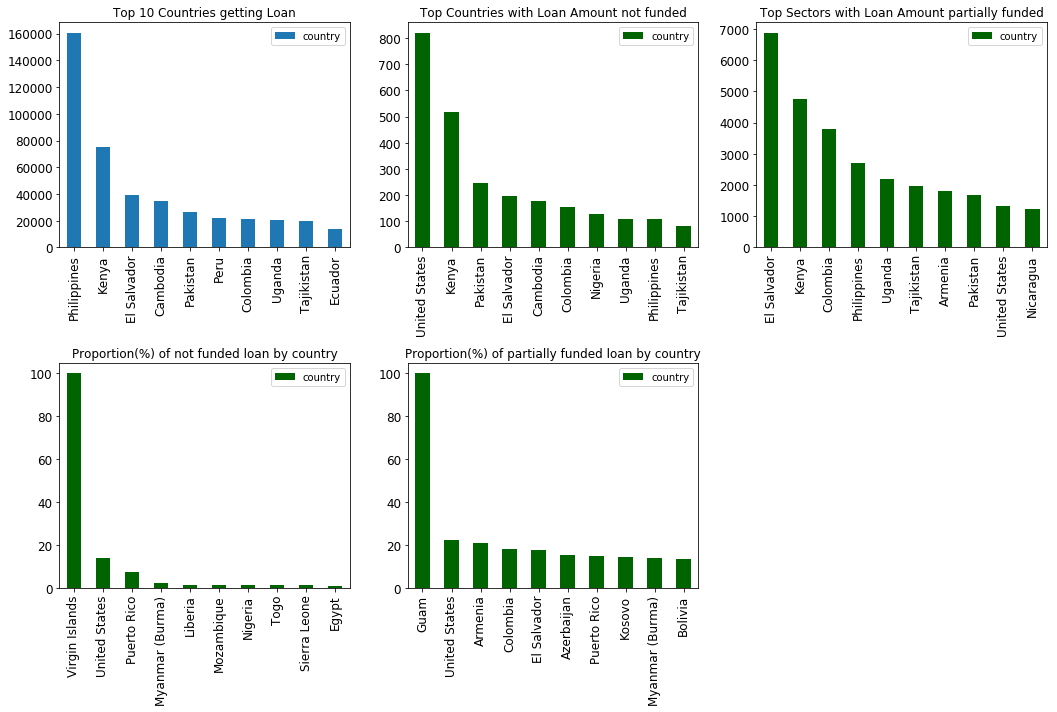

In [66]:
plt.subplot(2, 3, 1)
kiva_loans_data2['country'].value_counts().head(10).plot(kind='bar', title ="Top 10 Countries getting Loan", figsize=(15, 10), legend=True, fontsize=12)
plt.subplot(2, 3, 2)
kiva_loans_data2[kiva_loans_data2['label']==1]['country'].value_counts().head(10).plot(kind='bar', title ="Top Countries with Loan Amount not funded", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')
plt.subplot(2, 3, 3)
kiva_loans_data2[kiva_loans_data2['label']==2]['country'].value_counts().head(10).plot(kind='bar', title ="Top Sectors with Loan Amount partially funded", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')


plt.subplot(2, 3, 4)
(kiva_loans_data2[kiva_loans_data2['label']==1]['country'].value_counts()/kiva_loans_data2['country'].value_counts()*100).sort_values(ascending=False).head(10).plot(kind='bar', title ="Proportion(%) of not funded loan by country", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')
plt.subplot(2, 3, 5)
(kiva_loans_data2[kiva_loans_data2['label']==2]['country'].value_counts()/kiva_loans_data2['country'].value_counts()*100).sort_values(ascending=False).head(10).plot(kind='bar', title ="Proportion(%) of partially funded loan by country", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')

plt.tight_layout()

### Philippines, Kenya and El Salvador are the top 3 countries featuring in Loans dataset. United States, Kenya and Pakistan are the countries top countries with loan amount not funded. We can see that Virgin Islands, United States and Puerto Rico has highest not funded rate. Guam has highest partially funded rate because there is only 1 data from country Guan

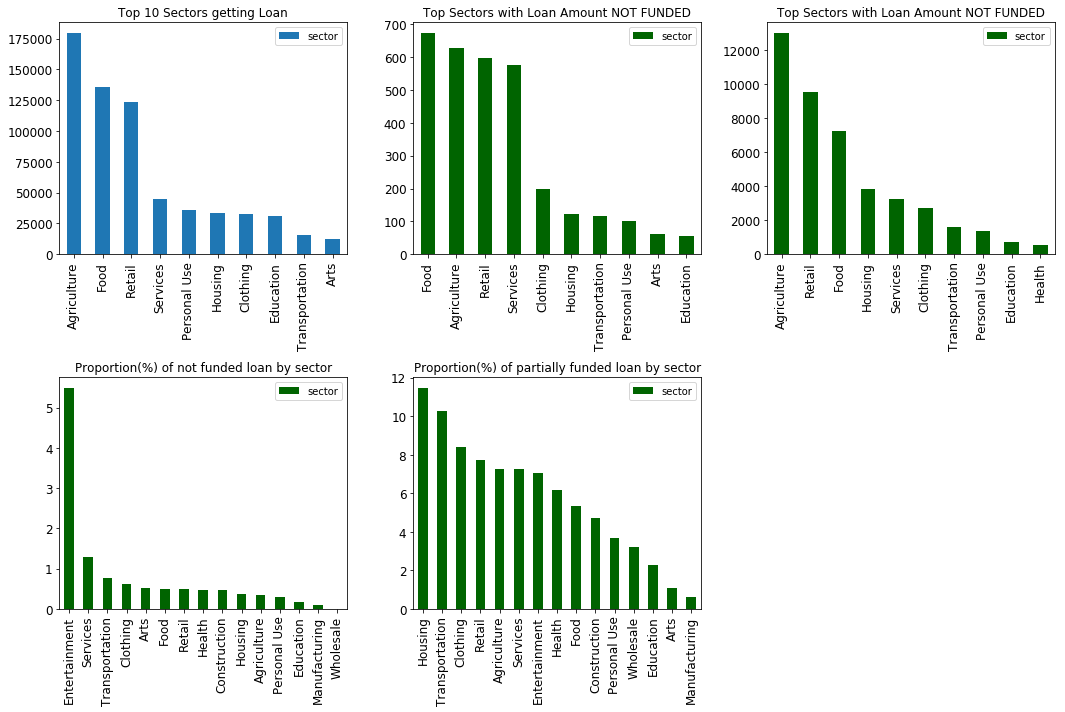

In [67]:
plt.subplot(2, 3, 1)
kiva_loans_data2['sector'].value_counts().head(10).plot(kind='bar', title ="Top 10 Sectors getting Loan", figsize=(15, 10), legend=True, fontsize=12)
plt.subplot(2, 3, 2)
kiva_loans_data2[kiva_loans_data2['label']==1]['sector'].value_counts().head(10).plot(kind='bar', title ="Top Sectors with Loan Amount NOT FUNDED", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')
plt.subplot(2, 3, 3)
kiva_loans_data2[kiva_loans_data2['label']==2]['sector'].value_counts().head(10).plot(kind='bar', title ="Top Sectors with Loan Amount NOT FUNDED", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')

plt.subplot(2, 3, 4)
(kiva_loans_data2[kiva_loans_data2['label']==1]['sector'].value_counts()/kiva_loans_data2['sector'].value_counts()*100).sort_values(ascending=False).plot(kind='bar', title ="Proportion(%) of not funded loan by sector", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')
plt.subplot(2, 3, 5)
(kiva_loans_data2[kiva_loans_data2['label']==2]['sector'].value_counts()/kiva_loans_data2['sector'].value_counts()*100).sort_values(ascending=False).plot(kind='bar', title ="Proportion(%) of partially funded loan by sector", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')

plt.tight_layout()

### Agriculture, Food and Retail are the top 3 sectors based on Loan Amount. And these are the top 3 that are not getting funds. Entertainment, Services and Transportation have higher not funded rate.

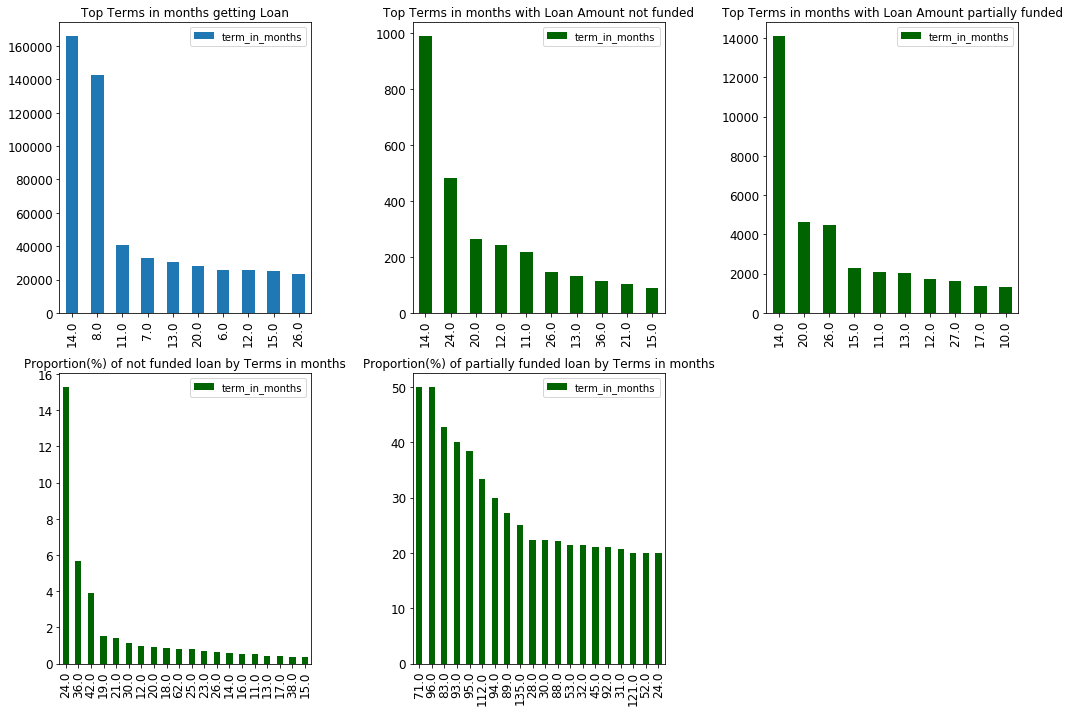

In [68]:
plt.subplot(2, 3, 1)
kiva_loans_data2['term_in_months'].value_counts().head(10).plot(kind='bar', title ="Top Terms in months getting Loan", figsize=(15, 10), legend=True, fontsize=12)
plt.subplot(2, 3, 2)
kiva_loans_data2[kiva_loans_data2['label']==1]['term_in_months'].value_counts().head(10).plot(kind='bar', title ="Top Terms in months with Loan Amount not funded", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')
plt.subplot(2, 3, 3)
kiva_loans_data2[kiva_loans_data2['label']==2]['term_in_months'].value_counts().head(10).plot(kind='bar', title ="Top Terms in months with Loan Amount partially funded", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')

plt.subplot(2, 3, 4)
(kiva_loans_data2[kiva_loans_data2['label']==1]['term_in_months'].value_counts()/kiva_loans_data2['term_in_months'].value_counts()*100).sort_values(ascending=False).head(20).plot(kind='bar', title ="Proportion(%) of not funded loan by Terms in months", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')
plt.subplot(2, 3, 5)
(kiva_loans_data2[kiva_loans_data2['label']==2]['term_in_months'].value_counts()/kiva_loans_data2['term_in_months'].value_counts()*100).sort_values(ascending=False).head(20).plot(kind='bar', title ="Proportion(%) of partially funded loan by Terms in months", figsize=(15, 10), legend=True, fontsize=12, color = 'DarkGreen')

plt.tight_layout()

### Didn't see a specific pattern for terms in months but we can see 24 months have very high not funded rate and 36, 42 months have relatively higher not funded rate. In Partially funded graph, we can see that 71 and 96 months have half partially funded rate.

## Model Building: Logistic Regression

### a. pick top 3 of the countries,  sector and term_in_months

In [69]:
model_data_1 = kiva_loans_data2[['label', 'loan_amount', 'sector', 'country', 'term_in_months', 'female', 'male', 'group']].copy(deep=True)
model_data_1['country_top3'] = ['country_yes' if c in ['Puerto Rico', 'United States','Virgin Islands'] else 'country_no' for c in model_data_1['country'] ]
dummy_size = pd.get_dummies(model_data_1['country_top3'])
model_data_1 = pd.concat([model_data_1,dummy_size ], axis =1)
model_data_1['sector_top3'] = ['sector_yes' if c in ['Entertainment', 'Transportation','Services'] else 'sector_no' for c in model_data_1['sector'] ]
dummy_size = pd.get_dummies(model_data_1['sector_top3'])
model_data_1 = pd.concat([model_data_1,dummy_size ], axis =1)

### a-1. oversampling of loan not funded/partially for train data

In [70]:
x = model_data_1[['label','loan_amount','term_in_months','female','group','male','country_yes','sector_yes']]
y = model_data_1['label'].values

x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.30, random_state=42)

#oversample the not funded loan in train data
not_funded_train_x = x_train[ x_train['label']== 1]
partially_funded_train_x = x_train[ x_train['label']== 2]
not_funded_train_y = y_train[y_train == 1]
partially_funded_train_y = y_train[y_train == 2]

repeat_x1 = pd.DataFrame( not_funded_train_x.values.repeat(189, axis=0), columns=not_funded_train_x.columns)
repeat_x2 = pd.DataFrame( partially_funded_train_x.values.repeat(13, axis=0), columns=partially_funded_train_x.columns)
repeat_y1 = pd.DataFrame( not_funded_train_y.repeat(189, axis=0))
repeat_y2 = pd.DataFrame( partially_funded_train_y.repeat(13, axis=0))

x_train = pd.concat([ x_train, repeat_x1,repeat_x2 ], ignore_index=True)
y_train = np.append(y_train ,repeat_y1)
y_train = np.append(y_train ,repeat_y2)

print("train data")
print(x_train.shape)
print(x_train['label'].value_counts())
print(len(y_train))

print("\ntest data")
print(x_test.shape)
print("1.0  ", np.count_nonzero(x_test['label'] == 1))
print("2.0  ",np.count_nonzero(x_test['label'] == 2))
print("3.0  ",np.count_nonzero(x_test['label'] == 3))
print(len(y_test))

x_train_final = x_train.loc[:,'loan_amount':]
x_test_final = x_test.loc[:,'loan_amount':]


logisticRegr = LogisticRegression(class_weight="balanced", solver="newton-cg", multi_class = 'multinomial', C=0.01)
logisticRegr.fit(x_train_final, y_train)

predictions = logisticRegr.predict(x_test_final)
score = logisticRegr.score(x_test_final, y_test)


print("Score from Logisitic Regression is %.2f%%" %(score*100))

print(classification_report(y_test, predictions))

train data
(1304785, 8)
1.0    435670
2.0    435638
3.0    433477
Name: label, dtype: int64
1304785

test data
(200095, 8)
1.0   961
2.0   13275
3.0   185859
200095
Score from Logisitic Regression is 69.09%
             precision    recall  f1-score   support

          1       0.03      0.28      0.05       961
          2       0.15      0.62      0.24     13275
          3       0.96      0.70      0.81    185859

avg / total       0.91      0.69      0.77    200095



### a-2. down sampling of loan funded/partially funded for train data

In [72]:
x = model_data_1[['label','loan_amount','term_in_months','female','group','male','country_yes','sector_yes']]
y = model_data_1['label'].values

x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.30, random_state=42)

print(x_train['label'].value_counts())

# doansample funded or partially fundedloan in train data
funded_train_x1 = x_train[x_train['label']== 3].sample(n=2293, random_state=42)
funded_train_x2 = x_train[x_train['label']== 2].sample(n=2293, random_state=42)
funded_train_y1 = x_train[x_train['label']== 3]['label'].sample(n=2293, random_state=42).values
funded_train_y2 = x_train[x_train['label']== 2]['label'].sample(n=2293, random_state=42).values


x_train = pd.concat([x_train[x_train['label']== 1], funded_train_x1, funded_train_x2], ignore_index=True)
y_train = np.append(y_train[y_train == 1], funded_train_y1 )
y_train = np.append(y_train, funded_train_y2 )

print("train data")
print(x_train.shape)
print(x_train['label'].value_counts())
print(len(y_train))

print("\ntest data")
print(x_test.shape)
print("1.0  ", np.count_nonzero(x_test['label'] == 1))
print("2.0  ",np.count_nonzero(x_test['label'] == 2))
print("3.0  ",np.count_nonzero(x_test['label'] == 3))
print(len(y_test))

x_train_final = x_train.loc[:,'loan_amount':]
x_test_final = x_test.loc[:,'loan_amount':]

logisticRegr = LogisticRegression(class_weight="balanced", solver="newton-cg", multi_class = 'multinomial', C=0.01)
logisticRegr.fit(x_train_final, y_train)
predictions = logisticRegr.predict(x_test_final)
score = logisticRegr.score(x_test_final, y_test)


print("Score from Logisitic Regression is %.2f%%" %(score*100))

print(classification_report(y_test, predictions))

3    433477
2     31117
1      2293
Name: label, dtype: int64
train data
(6879, 8)
3    2293
2    2293
1    2293
Name: label, dtype: int64
6879

test data
(200095, 8)
1.0   961
2.0   13275
3.0   185859
200095
Score from Logisitic Regression is 68.88%
             precision    recall  f1-score   support

          1       0.02      0.31      0.04       961
          2       0.15      0.61      0.25     13275
          3       0.97      0.70      0.81    185859

avg / total       0.91      0.69      0.77    200095



### a-3. original sampling of loan funded/partially funded for train data

In [73]:
x = model_data_1[['label','loan_amount','term_in_months','female','group','male','country_yes','sector_yes']]
y = model_data_1['label'].values

x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.30, random_state=42)


print("train data")
print(x_train.shape)
print(x_train['label'].value_counts())
print(len(y_train))

print("\ntest data")
print(x_test.shape)
print("1.0  ", np.count_nonzero(x_test['label'] == 1))
print("2.0  ",np.count_nonzero(x_test['label'] == 2))
print("3.0  ",np.count_nonzero(x_test['label'] == 3))
print(len(y_test))

x_train_final = x_train.loc[:,'loan_amount':]
x_test_final = x_test.loc[:,'loan_amount':]


logisticRegr = LogisticRegression(class_weight="balanced", solver="newton-cg", multi_class = 'multinomial', C=0.01)
logisticRegr.fit(x_train_final, y_train)
predictions = logisticRegr.predict(x_test_final)
score = logisticRegr.score(x_test_final, y_test)


print("Score from Logisitic Regression is %.2f%%" %(score*100))

print(classification_report(y_test, predictions))

train data
(466887, 8)
3    433477
2     31117
1      2293
Name: label, dtype: int64
466887

test data
(200095, 8)
1.0   961
2.0   13275
3.0   185859
200095
Score from Logisitic Regression is 69.06%
             precision    recall  f1-score   support

          1       0.03      0.28      0.05       961
          2       0.15      0.62      0.24     13275
          3       0.96      0.70      0.81    185859

avg / total       0.91      0.69      0.77    200095



### b. consider all the countries and sector

In [74]:
model_data_2 = kiva_loans_data2[['label', 'loan_amount', 'sector', 'country', 'term_in_months', 'female', 'male', 'group']].copy(deep=True)

dummy_1 = pd.get_dummies(model_data_2['sector'])
model_data_2 = pd.concat([model_data_2,dummy_1 ], axis =1)

dummy_2 = pd.get_dummies(model_data_2['country'])
model_data_2 = pd.concat([model_data_2,dummy_2 ], axis =1)

### b-1. oversampling of loan not funded/partially funded for train data

In [75]:
x = model_data_2.drop(['sector', 'country'], axis = 1)
y = model_data_2['label'].values


x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.30, random_state=42)

#oversample the not funded loan in train data
not_funded_train_x = x_train[ x_train['label']== 1]
partially_funded_train_x = x_train[ x_train['label']== 2]
not_funded_train_y = y_train[y_train == 1]
partially_funded_train_y = y_train[y_train == 2]

repeat_x1 = pd.DataFrame( not_funded_train_x.values.repeat(189, axis=0), columns=not_funded_train_x.columns)
repeat_x2 = pd.DataFrame( partially_funded_train_x.values.repeat(13, axis=0), columns=partially_funded_train_x.columns)
repeat_y1 = pd.DataFrame( not_funded_train_y.repeat(189, axis=0))
repeat_y2 = pd.DataFrame( partially_funded_train_y.repeat(13, axis=0))

x_train = pd.concat([ x_train, repeat_x1,repeat_x2 ], ignore_index=True)
y_train = np.append(y_train ,repeat_y1)
y_train = np.append(y_train ,repeat_y2)

print("train data")
print(x_train.shape)
print(x_train['label'].value_counts())
print(len(y_train))

print("\ntest data")
print(x_test.shape)
print("1.0  ", np.count_nonzero(x_test['label'] == 1))
print("2.0  ",np.count_nonzero(x_test['label'] == 2))
print("3.0  ",np.count_nonzero(x_test['label'] == 3))
print(len(y_test))

x_train_final = x_train.loc[:,'loan_amount':]
x_test_final = x_test.loc[:,'loan_amount':]


logisticRegr = LogisticRegression(class_weight="balanced", solver="newton-cg", multi_class = 'multinomial', C=0.01)
logisticRegr.fit(x_train_final, y_train)
predictions = logisticRegr.predict(x_test_final)
score = logisticRegr.score(x_test_final, y_test)


print("Score from Logisitic Regression is %.2f%%" %(score*100))

print(classification_report(y_test, predictions))

train data
(1304785, 108)
1.0    435670
2.0    435638
3.0    433477
Name: label, dtype: int64
1304785

test data
(200095, 108)
1.0   961
2.0   13275
3.0   185859
200095
Score from Logisitic Regression is 61.49%
             precision    recall  f1-score   support

          1       0.02      0.63      0.03       961
          2       0.18      0.64      0.28     13275
          3       0.98      0.61      0.75    185859

avg / total       0.92      0.61      0.72    200095



### b-2. down sampling of loan funded/partially funded for train data

In [76]:
x = model_data_2.drop(['sector', 'country'], axis = 1)
y = model_data_2['label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

print(x_train['label'].value_counts())

# doansample funded or partially fundedloan in train data
funded_train_x1 = x_train[x_train['label']== 3].sample(n=2293, random_state=42)
funded_train_x2 = x_train[x_train['label']== 2].sample(n=2293, random_state=42)
funded_train_y1 = x_train[x_train['label']== 3]['label'].sample(n=2293, random_state=42).values
funded_train_y2 = x_train[x_train['label']== 2]['label'].sample(n=2293, random_state=42).values


x_train = pd.concat([x_train[x_train['label']== 1], funded_train_x1, funded_train_x2], ignore_index=True)
y_train = np.append(y_train[y_train == 1], funded_train_y1 )
y_train = np.append(y_train, funded_train_y2 )

print("train data")
print(x_train.shape)
print(x_train['label'].value_counts())
print(len(y_train))

print("\ntest data")
print(x_test.shape)
print("1.0  ", np.count_nonzero(x_test['label'] == 1))
print("2.0  ",np.count_nonzero(x_test['label'] == 2))
print("3.0  ",np.count_nonzero(x_test['label'] == 3))
print(len(y_test))

x_train_final = x_train.loc[:,'loan_amount':]
x_test_final = x_test.loc[:,'loan_amount':]


logisticRegr = LogisticRegression(class_weight="balanced", solver="newton-cg", multi_class = 'multinomial', C=0.01)
logisticRegr.fit(x_train_final, y_train)
predictions = logisticRegr.predict(x_test_final)
score = logisticRegr.score(x_test_final, y_test)

print("Score from Logisitic Regression is %.2f%%" %(score*100))

print(classification_report(y_test, predictions))

3    433477
2     31117
1      2293
Name: label, dtype: int64
train data
(6879, 108)
3    2293
2    2293
1    2293
Name: label, dtype: int64
6879

test data
(200095, 108)
1.0   961
2.0   13275
3.0   185859
200095
Score from Logisitic Regression is 66.15%
             precision    recall  f1-score   support

          1       0.02      0.46      0.03       961
          2       0.17      0.63      0.27     13275
          3       0.97      0.66      0.79    185859

avg / total       0.92      0.66      0.75    200095



### b-3. original sampling of loan funded/partially funded for train data

In [77]:
x = model_data_2.drop(['sector', 'country'], axis = 1)
y = model_data_2['label'].values

x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.30, random_state=42)


print("train data")
print(x_train.shape)
print(x_train['label'].value_counts())
print(len(y_train))

print("\ntest data")
print(x_test.shape)
print("1.0  ", np.count_nonzero(x_test['label'] == 1))
print("2.0  ",np.count_nonzero(x_test['label'] == 2))
print("3.0  ",np.count_nonzero(x_test['label'] == 3))
print(len(y_test))

x_train_final = x_train.loc[:,'loan_amount':]
x_test_final = x_test.loc[:,'loan_amount':]


logisticRegr = LogisticRegression(class_weight="balanced", solver="newton-cg", multi_class = 'multinomial', C=0.01)
logisticRegr.fit(x_train_final, y_train)
predictions = logisticRegr.predict(x_test_final)
score = logisticRegr.score(x_test_final, y_test)


print("Score from Logisitic Regression is %.2f%%" %(score*100))

print(classification_report(y_test, predictions))

train data
(466887, 108)
3    433477
2     31117
1      2293
Name: label, dtype: int64
466887

test data
(200095, 108)
1.0   961
2.0   13275
3.0   185859
200095
Score from Logisitic Regression is 61.50%
             precision    recall  f1-score   support

          1       0.02      0.63      0.03       961
          2       0.18      0.64      0.28     13275
          3       0.98      0.61      0.75    185859

avg / total       0.92      0.61      0.72    200095



### c. Multi-Class Logistic Classification Modelling

In [78]:
model_data_3 = kiva_loans_data2[['label', 'loan_amount', 'sector', 'country', 'term_in_months', 'female','male', 'group']].copy(deep=True)

dummy_1 = pd.get_dummies(model_data_3['sector'])
model_data_3 = pd.concat([model_data_3,dummy_1 ], axis =1)

dummy_2 = pd.get_dummies(model_data_3['country'])
model_data_3 = pd.concat([model_data_3,dummy_2 ], axis =1)

dummy_3 = pd.get_dummies(model_data_3['label'], prefix='funded')
model_data_3 = pd.concat([model_data_3,dummy_3 ], axis =1)


x = model_data_3.drop(['sector', 'country'], axis = 1)
y = model_data_3['label'].values

x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.30, random_state=42)

x_train_final = x_train.loc[:,'loan_amount':].reset_index(drop=True)
x_test_final = x_test.loc[:,'loan_amount':].reset_index(drop=True)


classifiers = set(kiva_loans_data2['label'])
model_3 = {}
for mdl_idx in classifiers:
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_train_final.iloc[:,:107],x_train_final['funded_{}'.format(mdl_idx)])
    model_3[mdl_idx]=logisticRegr
model_3

{1: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 2: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 3: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)}

In [79]:


coefs = {}
for mdl_k, mdl_v in model_3.items():
    coefs[mdl_k]=mdl_v.coef_
    
    
lgr_probabilities = pd.DataFrame(columns=classifiers)
for mdl_key, mdl_model in model_3.items():
    lgr_probabilities[mdl_key] = mdl_model.predict_proba(x_test_final.iloc[:,:107])[:,1]
lgr_probabilities.head()

,1,2,3
0,0.001538,0.055580,0.947723
1,0.012237,0.050077,0.943853
2,0.008240,0.042974,0.948762
3,0.004584,0.035590,0.958872
4,0.000673,0.018362,0.981955


In [80]:
predicted_funded = lgr_probabilities.idxmax(axis=1)
x_test = x_test.reset_index(drop=True)
pred_funded = lgr_probabilities.max(axis=1)
lgr_accuracy = len(x_test[x_test['label']==predicted_funded])/len(x_test)
pd.crosstab(x_test['label'],predicted_funded)

col_0,2,3
label,,
1,27,934
2,294,12981
3,469,185390


In [ ]:
#predicted_funded = lgr_probabilities.idxmax(axis=1)
#pred_funded = lgr_probabilities.max(axis=1)
#lgr_accuracy = len(x_test[x_test['label']==predicted_funded])/len(x_test)
#pd.crosstab(x_test['label'],predicted_funded)

In [81]:
print('Logistic Regression Accuracy - {0:.4f}%'.format(lgr_accuracy*100))

Logistic Regression Accuracy - 92.7979%


| Model                                 | Overall Accuracy | 0 score | 1 score | 2 score | 
|-------------------------------------|------------------|-------- |---------|---------|
| A.Top 3 countries + Top 3 Sectors                         |       92.6%      |   32%   |   96%   |  96%   | 
| Over sampling                        |       92.8%      |    0%   |   96%   |  96%   |   
| Down sampling                             |       93.1%      |    8%   |   96%   |  96%   |     
| Original sampling                  |       92.8%      |    7%   |   96%   |  96%   |    
| B.All countries and sectors   |       72.6%      |   28%   |   83%   |  96%   |    
| Over sampling        |      74.69%      |   75%   |   74%   |  96%   | 
| Over sampling       |      79.97%      |   81%   |   79%   |  96%   |    
| Original sampling                  |       65.4%      |   23%   |   78%   |  96%   |     
| Multi-Class Logistic Classification  |      70.47%      |   72%   |   69%   |   96%   |    